<a href="https://colab.research.google.com/github/Anusri-J/Shopper_Spectrum/blob/main/Shopper_Spectrum_Segmentation_and_Recommendations_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1) Setup & imports**

In [33]:
# Colab cell: 1 - Install dependencies and imports
!pip install -q pandas numpy scikit-learn matplotlib seaborn plotly joblib

# If running streamlit in colab, pyngrok helps expose the local server (optional).
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import joblib
import os
import warnings
warnings.filterwarnings("ignore")

**2) Load dataset**

In [34]:
#Loading dataset
file_name = '/content/online_retail.csv'  # <-- change to your actual file

df = pd.read_csv(file_name, encoding='ISO-8859-1', low_memory=False)
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


**3) Row-level analysis (inspect each row and flag issues) — topic: Row Analysis**

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [36]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [37]:
df.shape

(541909, 8)

In [38]:
# Row-level diagnostics function
def row_level_diagnostics(df):
    df = df.copy()
    # parse invoice date if necessary
    if not np.issubdtype(df['InvoiceDate'].dtype, np.datetime64):
        df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
    # create basic flags
    df['missing_customer'] = df['CustomerID'].isna()
    df['is_cancelled_invoice'] = df['InvoiceNo'].astype(str).str.startswith('C', na=False)
    df['negative_or_zero_qty'] = df['Quantity'] <= 0
    df['negative_or_zero_price'] = df['UnitPrice'] <= 0
    # total price
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
    # duplicates: identical InvoiceNo + StockCode + Quantity + UnitPrice and same date
    dup_cols = ['InvoiceNo','StockCode','Quantity','UnitPrice','InvoiceDate']
    df['possible_duplicate'] = df.duplicated(subset=dup_cols, keep=False)
    # outliers: extremely large quantities or prices (stat-based)
    qty_q3 = df['Quantity'].quantile(0.75)
    qty_iqr = qty_q3 - df['Quantity'].quantile(0.25)
    price_q3 = df['UnitPrice'].quantile(0.75)
    price_iqr = price_q3 - df['UnitPrice'].quantile(0.25)
    df['qty_outlier'] = df['Quantity'] > (qty_q3 + 3*qty_iqr)
    df['price_outlier'] = df['UnitPrice'] > (price_q3 + 3*price_iqr)
    # suspicious description blanks
    df['missing_description'] = df['Description'].isna() | (df['Description'].astype(str).str.strip() == '')
    return df

diag_df = row_level_diagnostics(df)
# Quick summary counts
summary = pd.DataFrame({
    'total_rows': [len(diag_df)],
    'missing_customer_count': [diag_df['missing_customer'].sum()],
    'cancelled_invoices': [diag_df['is_cancelled_invoice'].sum()],
    'neg_or_zero_qty': [diag_df['negative_or_zero_qty'].sum()],
    'neg_or_zero_price': [diag_df['negative_or_zero_price'].sum()],
    'possible_duplicates': [diag_df['possible_duplicate'].sum()],
    'qty_outliers': [diag_df['qty_outlier'].sum()],
    'price_outliers': [diag_df['price_outlier'].sum()],
    'missing_description': [diag_df['missing_description'].sum()]
})
display(summary)
# Optionally save detailed diagnostic CSV for review
diag_df.to_csv('/content/row_level_diagnostics.csv', index=False)
print("Saved detailed per-row diagnostics to /content/row_level_diagnostics.csv")

,total_rows,missing_customer_count,cancelled_invoices,neg_or_zero_qty,neg_or_zero_price,possible_duplicates,qty_outliers,price_outliers,missing_description
0,541909,135080,9288,10624,2517,10151,20714,12848,1454


Saved detailed per-row diagnostics to /content/row_level_diagnostics.csv


**4) Preprocessing & cleaning (topic: Data Preprocessing)**

In [39]:
# Colab cell: 4 - Cleaning pipeline
def clean_transactions(df):
    df = df.copy()
    # parse date
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
    # Remove missing CustomerID
    df = df[~df['CustomerID'].isna()]
    # Exclude cancelled invoices (starting with 'C')
    df = df[~df['InvoiceNo'].astype(str).str.startswith('C', na=False)]
    # Remove negative/zero quantity and price
    df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
    # Strip descriptions
    df['Description'] = df['Description'].astype(str).str.strip()
    # Create TotalPrice
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
    # Ensure CustomerID is string (consistent)
    df['CustomerID'] = df['CustomerID'].astype(str).str.strip()
    # Reset index
    df = df.reset_index(drop=True)
    return df

clean_df = clean_transactions(df)
print("Rows before:", len(df), "Rows after cleaning:", len(clean_df))
clean_df.to_csv('/content/clean_transactions.csv', index=False)

Rows before: 541909 Rows after cleaning: 397884


**5) Exploratory Data Analysis (topic: EDA)**

In [40]:
# Top countries by transaction count and revenue
country_stats = clean_df.groupby('Country').agg({
    'InvoiceNo':'nunique',
    'TotalPrice':'sum',
    'Quantity':'sum'
}).rename(columns={'InvoiceNo':'num_invoices'}).sort_values('TotalPrice', ascending=False)
display(country_stats.head(20))

,num_invoices,TotalPrice,Quantity
Country,,,
United Kingdom,16646,7308391.554,4256740
Netherlands,94,285446.340,200361
EIRE,260,265545.900,140275
Germany,457,228867.140,119261
France,389,209024.050,111471
Australia,57,138521.310,83901
Spain,90,61577.110,27940
Switzerland,51,56443.950,30082
Belgium,98,41196.340,23237


In [41]:
# Top-selling products by revenue and quantity
product_stats = clean_df.groupby(['StockCode','Description']).agg({
    'Quantity':'sum',
    'TotalPrice':'sum'
}).sort_values('TotalPrice', ascending=False).reset_index()
display(product_stats.head(20))

,StockCode,Description,Quantity,TotalPrice
0,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,168469.60
1,22423,REGENCY CAKESTAND 3 TIER,12402,142592.95
2,85123A,WHITE HANGING HEART T-LIGHT HOLDER,36725,100448.15
3,85099B,JUMBO BAG RED RETROSPOT,46181,85220.78
4,23166,MEDIUM CERAMIC TOP STORAGE JAR,77916,81416.73
5,POST,POSTAGE,3120,77803.96
6,47566,PARTY BUNTING,15291,68844.33
7,84879,ASSORTED COLOUR BIRD ORNAMENT,35362,56580.34
8,M,Manual,7173,53779.93
9,23084,RABBIT NIGHT LIGHT,27202,51346.20


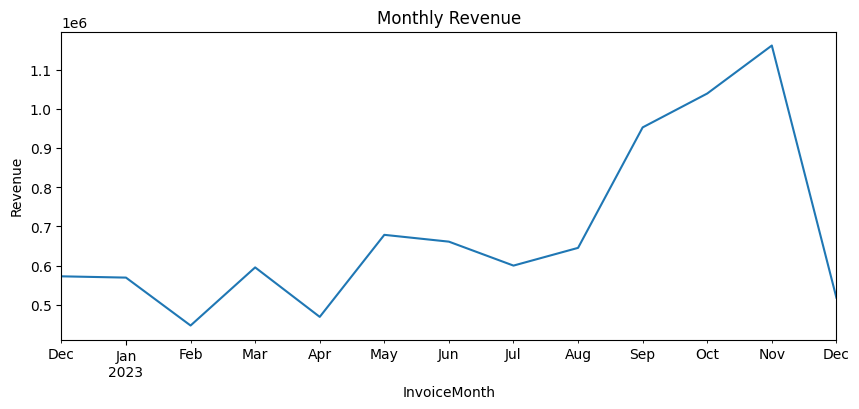

In [42]:
# Monthly sales trend
clean_df['InvoiceMonth'] = clean_df['InvoiceDate'].dt.to_period('M')
monthly = clean_df.groupby('InvoiceMonth')['TotalPrice'].sum().sort_index()
monthly.plot(kind='line', figsize=(10,4), title='Monthly Revenue')
plt.ylabel('Revenue')
plt.show()

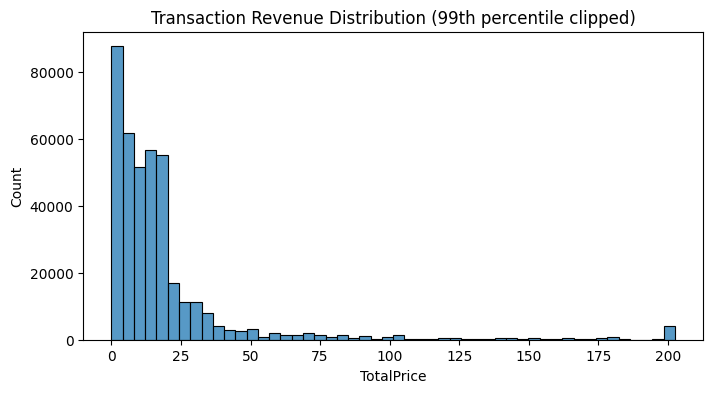

In [43]:
# Distribution of monetary per transaction
plt.figure(figsize=(8,4))
sns.histplot(clean_df['TotalPrice'].clip(upper=clean_df['TotalPrice'].quantile(0.99)), bins=50)
plt.title('Transaction Revenue Distribution (99th percentile clipped)')
plt.show()

In [44]:
# Save common outputs
country_stats.to_csv('/content/country_stats.csv')
product_stats.to_csv('/content/product_stats.csv', index=False)

**6) RFM calculation (topic: RFM)**

In [45]:
# Colab cell: 6 - RFM computation
def compute_rfm(df, reference_date=None):
    df = df.copy()
    if reference_date is None:
        reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
    # aggregate per customer
    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (reference_date - x.max()).days,
        'InvoiceNo': 'nunique',
        'TotalPrice': 'sum'
    }).rename(columns={'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'TotalPrice':'Monetary'})
    rfm = rfm.reset_index()
    return rfm, reference_date

rfm, ref_date = compute_rfm(clean_df)
print("Reference date used for recency:", ref_date)
display(rfm.describe())
rfm.to_csv('/content/rfm.csv', index=False)

Reference date used for recency: 2023-12-10 12:50:00


,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


**7) Scaling and clustering (topic: Clustering & KMeans)**

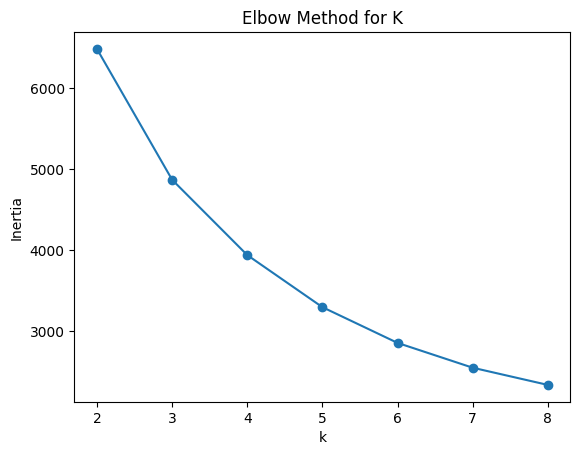

In [46]:
# Prepare RFM for clustering
rfm_model = rfm.copy()
# Option: log-transform Monetary and Frequency to reduce skew
rfm_model['Monetary_log'] = np.log1p(rfm_model['Monetary'])
rfm_model['Frequency_log'] = np.log1p(rfm_model['Frequency'])
rfm_model['Recency_log'] = np.log1p(rfm_model['Recency'])

features = ['Recency_log','Frequency_log','Monetary_log']
X = rfm_model[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method (inertia)
inertia = []
K = range(2,9)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

import matplotlib.pyplot as plt
plt.plot(K, inertia, '-o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for K')
plt.show()

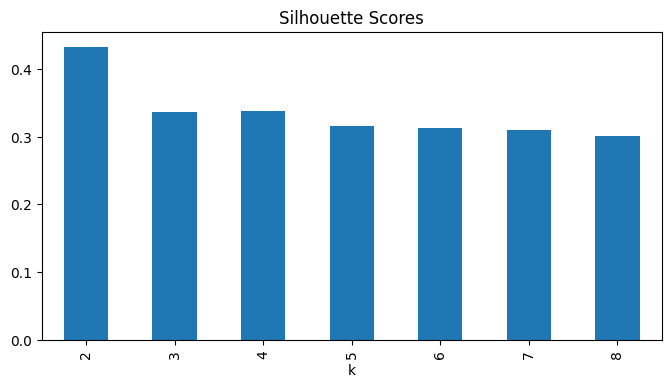

In [47]:
# Silhouette scores
sil_scores = []
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

pd.DataFrame({'k':K,'silhouette':sil_scores}).set_index('k').plot(kind='bar', legend=False, figsize=(8,4))
plt.title('Silhouette Scores')
plt.show()

# Choose k (example choose 4; adjust after inspecting elbow/silhouette)
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=50)
rfm_model['cluster'] = kmeans.fit_predict(X_scaled)

# Add original RFM values for interpretation
rfm_model['Recency'] = rfm['Recency']
rfm_model['Frequency'] = rfm['Frequency']
rfm_model['Monetary'] = rfm['Monetary']


In [48]:
# Cluster summary
cluster_summary = rfm_model.groupby('cluster').agg({
    'Recency':'mean','Frequency':'mean','Monetary':'mean','CustomerID':'count'
}).rename(columns={'CustomerID':'count'}).reset_index()
display(cluster_summary)

,cluster,Recency,Frequency,Monetary,count
0,0,11.983333,13.658333,8024.993500,720
1,1,185.357053,1.322418,348.849132,1588
2,2,19.532710,2.052570,532.807407,856
3,3,69.614991,4.123509,1808.651638,1174


In [49]:
# Save scaler and kmeans model
joblib.dump(scaler, '/content/rfm_scaler.joblib')
joblib.dump(kmeans, '/content/kmeans_rfm.joblib')
rfm_model.to_csv('/content/rfm_with_clusters.csv', index=False)
print("Saved scaler and cluster model to /content")

Saved scaler and cluster model to /content


**8) Item-based Collaborative Filtering (topic: Recommendations)**

In [50]:
# Colab cell: 8 - Build item-item collaborative filtering model
# Create customer x product pivot table (binary or counts)
cust_item = clean_df.groupby(['CustomerID','StockCode'])['Quantity'].sum().unstack(fill_value=0)

# Option 1: use binary purchases (1 if purchased)
cust_item_bin = (cust_item > 0).astype(int)

# Compute item-item cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
item_matrix = cust_item_bin.T  # items x customers
similarity = cosine_similarity(item_matrix.values)  # shape: n_items x n_items
item_index = item_matrix.index.tolist()

# Wrap into DataFrame for ease
item_sim_df = pd.DataFrame(similarity, index=item_index, columns=item_index)
# Save
item_sim_df.to_csv('/content/item_similarity.csv')
joblib.dump(item_sim_df, '/content/item_similarity_df.joblib')
print("Saved item similarity matrix and dataframe to /content")

# Helper: get top N similar items given a StockCode
def get_similar_items(stockcode, top_n=5):
    if str(stockcode) not in item_sim_df.index:
        return []
    sims = item_sim_df[stockcode].drop(stockcode).sort_values(ascending=False)
    return sims.head(top_n)

# Demo
some_item = item_index[0]
print("Top 5 similar to", some_item)
print(get_similar_items(some_item, top_n=5))

Saved item similarity matrix and dataframe to /content
Top 5 similar to 10002
90103     0.223607
21826     0.197642
90059E    0.182574
90101     0.182574
90059F    0.182574
Name: 10002, dtype: float64


**9) Save all artifacts (topic: Save Models & Files)**

In [51]:
# Assuming your main DataFrame is called 'data' or 'df'
# and has columns 'StockCode' and 'Description'

sc_desc = (
    df[['StockCode', 'Description']]
    .drop_duplicates()
    .set_index('StockCode')['Description']
    .to_dict()
)

# Now save the mapping
joblib.dump(sc_desc, '/content/stockcode_description_map.pkl')

print("✅ stockcode_description_map.pkl saved successfully!")

✅ stockcode_description_map.pkl saved successfully!


**10) Extra utilities (topic: Useful helper functions)**

In [52]:
# Colab cell: extra utilities
# Export cluster label mapping helper (manual)
def create_cluster_label_mapping(cluster_summary_df):
    # Manually inspect cluster_summary_df and return a mapping {cluster: label}
    print(cluster_summary_df)
    # Example (adjust after inspection):
    example_map = {0:'Regular',1:'High-Value',2:'Occasional',3:'At-Risk'}
    return example_map

cluster_summary = pd.read_csv('/content/rfm_with_clusters.csv').groupby('cluster').agg({'Recency':'mean','Frequency':'mean','Monetary':'mean','CustomerID':'count'}).rename(columns={'CustomerID':'count'}).reset_index()
display(cluster_summary)
mapping = create_cluster_label_mapping(cluster_summary)
# Save mapping
joblib.dump(mapping, '/content/cluster_label_map.pkl')
print("Saved example cluster label mapping to /content/cluster_label_map.pkl")

,cluster,Recency,Frequency,Monetary,count
0,0,11.983333,13.658333,8024.993500,720
1,1,185.357053,1.322418,348.849132,1588
2,2,19.532710,2.052570,532.807407,856
3,3,69.614991,4.123509,1808.651638,1174


   cluster     Recency  Frequency     Monetary  count
0        0   11.983333  13.658333  8024.993500    720
1        1  185.357053   1.322418   348.849132   1588
2        2   19.532710   2.052570   532.807407    856
3        3   69.614991   4.123509  1808.651638   1174
Saved example cluster label mapping to /content/cluster_label_map.pkl


**10) Streamlit app**

In [53]:
!pip install -q streamlit
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
import subprocess
subprocess.Popen(["./cloudflared-linux-amd64", "tunnel", "--url", "http://localhost:8501"])
!nohup /content/cloudflared-linux-amd64 tunnel --url http://localhost:8501 &

--2025-10-30 12:32:53--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2025.10.0/cloudflared-linux-amd64 [following]
--2025-10-30 12:32:53--  https://github.com/cloudflare/cloudflared/releases/download/2025.10.0/cloudflared-linux-amd64
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/3cf4ee00-005b-4d19-8b1e-15145bd129bf?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-10-30T13%3A31%3A11Z&rscd=attachment%3B+filename%3Dcloudflared-linux-amd64&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-10-30

In [54]:
%%writefile Shopper_Spectrum.py
import streamlit as st
import pandas as pd
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler

# -------------------- PAGE CONFIG --------------------
st.set_page_config(page_title='Shopper Spectrum', layout='wide')

# -------------------- LOAD MODELS & DATA --------------------
@st.cache_data
def load_artifacts():
    sim_df = joblib.load('/content/item_similarity_df.joblib')
    sc_desc = joblib.load('/content/stockcode_description_map.pkl')
    kmeans = joblib.load('/content/kmeans_rfm.joblib')
    scaler = joblib.load('/content/rfm_scaler.joblib')
    rfm_df = pd.read_csv('/content/rfm_with_clusters.csv')
    try:
        cluster_map = joblib.load('/content/cluster_label_map.pkl')
    except:
        cluster_map = {}
    return sim_df, sc_desc, kmeans, scaler, rfm_df, cluster_map

sim_df, sc_desc, kmeans, scaler, rfm_df, cluster_map = load_artifacts()

# -------------------- APP TITLE --------------------
st.title('🛍️ Shopper Spectrum: Segmentation & Recommendations')

# -------------------- SIDEBAR MENU --------------------
menu = st.sidebar.radio("Home", ("Recommendation", "Clustering", "Explore Products"))
st.write(f"You have selected: **{menu}**")

# -------------------- PRODUCT RECOMMENDATION --------------------
if menu == 'Recommendation':
    st.header('🧾 Product Recommendation (Item-based Collaborative Filtering)')
    input_mode = st.radio('Search by', ['StockCode', 'Product Name Search'])

    if input_mode == 'StockCode':
        scode = st.text_input('Enter StockCode (e.g., 85123)', value='')
        n = st.slider('Number of recommendations', 1, 10, 5)
        if st.button('Get Recommendations'):
            if scode.strip() == '':
                st.warning('Please enter a StockCode.')
            elif scode not in sim_df.index:
                st.error('StockCode not found in similarity matrix.')
            else:
                sims = sim_df[scode].drop(scode).sort_values(ascending=False).head(n)
                results = []
                for idx, score in sims.items():
                    desc = sc_desc.get(idx, 'Unknown')
                    results.append({
                        'StockCode': idx,
                        'Description': desc,
                        'Similarity': round(float(score), 3)
                    })
                st.table(pd.DataFrame(results))

    else:
        q = st.text_input('Enter product name (partial match)', value='')
        n = st.slider('Number of recommendations', 1, 10, 5)
        if st.button('Search & Recommend'):
            if q.strip() == '':
                st.warning('Please enter a product name.')
            else:
                matches = [(k, v) for k, v in sc_desc.items() if q.lower() in str(v).lower()]
                if not matches:
                    st.info('No product matched that name.')
                else:
                    stockcode = matches[0][0]
                    st.write(f"Found match: **{matches[0][1]}** (StockCode: {stockcode})")
                    if stockcode not in sim_df.index:
                        st.error('No similarity info for this product.')
                    else:
                        sims = sim_df[stockcode].drop(stockcode).sort_values(ascending=False).head(n)
                        results = []
                        for idx, score in sims.items():
                            desc = sc_desc.get(idx, 'Unknown')
                            results.append({
                                'StockCode': idx,
                                'Description': desc,
                                'Similarity': round(float(score), 3)
                            })
                        st.table(pd.DataFrame(results))

# -------------------- CUSTOMER SEGMENTATION --------------------
elif menu == 'Clustering':
    st.header('👥 Customer Segmentation (RFM → Cluster)')
    recency = st.number_input('Recency (days since last purchase)', min_value=0, value=30)
    frequency = st.number_input('Frequency (number of purchases)', min_value=0, value=5)
    monetary = st.number_input('Monetary (total spend)', min_value=0.0, value=100.0, step=1.0)

    if st.button('Predict Cluster'):
        feat = np.array([[np.log1p(recency), np.log1p(frequency), np.log1p(monetary)]])
        feat_scaled = scaler.transform(feat)
        pred = int(kmeans.predict(feat_scaled)[0])

        label = cluster_map.get(pred, f'Cluster {pred}')
        st.success(f'Predicted cluster: **{label}**')

# -------------------- EXPLORE PRODUCTS --------------------
elif menu == 'Explore Products':
    st.header('📦 Explore Top Products')
    try:
        prod_df = pd.read_csv('/content/product_stats.csv')
        st.write('### Top 50 Products by Revenue:')
        st.dataframe(prod_df.head(50))
    except Exception as e:
        st.error('⚠️ `product_stats.csv` not found. Please run the preprocessing notebook first.')

Overwriting Shopper_Spectrum.py


In [55]:
!streamlit run /content/Shopper_Spectrum.py &>/content/logs.txt &

In [56]:
!grep -o 'https://.*\.trycloudflare.com' nohup.out | head -n 1 | xargs -I {} echo "Your tunnel url {}"

Your tunnel url https://bite-combination-middle-vid.trycloudflare.com
